<a href="https://colab.research.google.com/github/Sreys10/DSA/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Transformers


using transformer for images

### tokenisation
 Instead of splitting up text into tokens, it converts the original image into patches of images. In other words, it cuts the image into a number of pieces horizontally and vertically

 ![image1.png](<image1.png>)

## CLIP: Connecting Text and Images (Contrastive Language-Image Pre training)
 CLIP is an embedding model that can compute embeddings of both images
 and texts. The resulting embeddings lie in the same vector space, which
 means that the embeddings of images can be compared with the
 embeddings of text.3 This comparison capability makes CLIP, and similar
 models, usable for tasks such as:

In [1]:
#using openclip

from urllib.request import urlopen
from PIL import Image

#load the Image
puppy_path= "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"

image= Image.open(urlopen(puppy_path)).convert("RGB")

caption= "a puppy playing in the snow"

Since we have a caption for this image, we can use OpenCLIP to generate embeddings for both.

 To do so, we load in three models:

 A tokenizer for tokenizing the textual input

 A preprocessor to preprocess and resize the image

 The main model that converts the previous outputs to embeddings

In [2]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

#load a tokenizer
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

#load the processor
clip_processor = CLIPProcessor.from_pretrained(model_id)

#main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [3]:
#tokenize our input
inputs= clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [4]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [5]:
#creat a text embeddings
text_embeddings= model.get_text_features(**inputs)
text_embeddings.shape

torch.Size([1, 512])

In [6]:
processed_image = clip_processor(
    text=None, images=image, return_tensors="pt"
)

# Now extract the actual tensor from the dictionary
pixel_values = processed_image["pixel_values"]

# Get the shape of the tensor
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

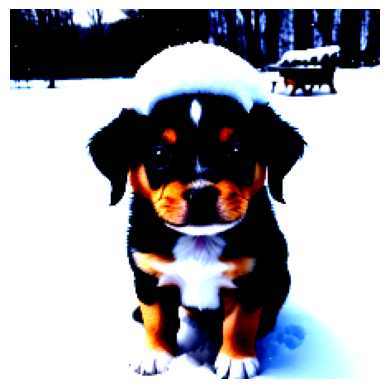

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Prepare image for visualization
img = pixel_values.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum("ijk->jik", img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis("off")

In [8]:
#create the image embeddings
image_embeddings= model.get_image_features(pixel_values)
image_embeddings.shape

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

torch.Size([1, 512])

In [9]:
import numpy as np

# Detach from the computation graph and convert to NumPy
text_embeddings = text_embeddings.detach().cpu().numpy()
image_embeddings = image_embeddings.detach().cpu().numpy()

# ✅ Normalize using NumPy
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=-1, keepdims=True)
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=-1, keepdims=True)

# ✅ Compute similarity
score = np.dot(text_embeddings, image_embeddings.T)
score


array([[0.33149642]], dtype=float32)

## BLIP-2: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation 2.
 BLIP-2 is an easy-to
use and modular technique that allows for introducing vision capabilities to
 existing language models

Instead of building the architecture from scratch, BLIP-2 bridges the vision
language gap by building a bridge, named the Querying Transformer (Q
Former), that connects a pretrained image encoder and a pretrained LLM.5
 By leveraging pretrained models, BLIP-2 only needs to train the bridge
 without needing to train the image encoder and LLM from scratch. It makes
 great use of the technology and models that are already out there!

 ![image2.png](<image2.png>)

In [11]:
#preprocess multimodal inputs
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

#load processor and main model
# Use "Salesforce/blip2-opt-2.7b" instead of "Salesforce/blip2-opt-1.7b"
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# Use "Salesforce/blip2-opt-2.7b" instead of "Salesforce/blip2-opt-1.7b"
model= Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype= torch.float16)

#send the model to gpu
device = "cuda"  if torch.cuda.is_available()  else "cpu"
model.to(device)

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

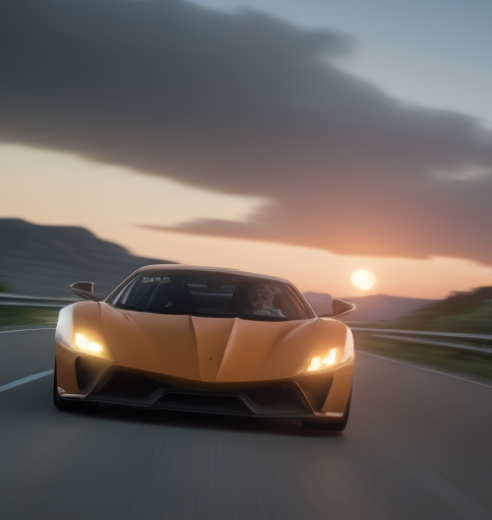

In [12]:
 #Load image of a supercar
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [13]:
#preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [15]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [16]:
#preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

#convert input ids back to tokens
tokens= blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [19]:
#replace the space token with an underscore
tokens= [token.replace("Ġ", "_")for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

## Image Captioning
The most straightforward usage of a model like BLIP-2 is to create captions
 of images that you have in your data. You might be a store that wants to
 create descriptions of its clothing or perhaps you are a photographer that
 does not have the time to manually label the 1,000+ pictures of a wedding.

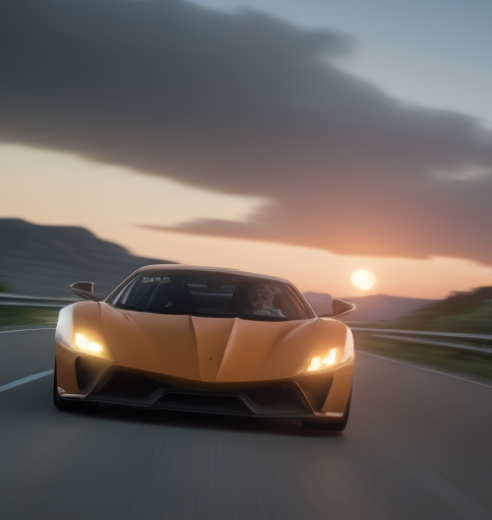

In [21]:
#load the image
image =Image.open(urlopen(car_path)).convert("RGB")

#convert an image into inputs and preprocess it
inputs=blip_processor(image, return_tensors= "pt").to(device, torch.float16)
image

In [24]:
#convert the image into token ids
generated_ids= model.generate(**inputs, max_new_tokens= 20)

#generate text from the image ids
generated_text= blip_processor.batch_decode(
    generated_ids, skip_special_tokens= True
)

generated_text = generated_text[0].strip()
generated_text

'an orange supercar driving on the road at sunset'

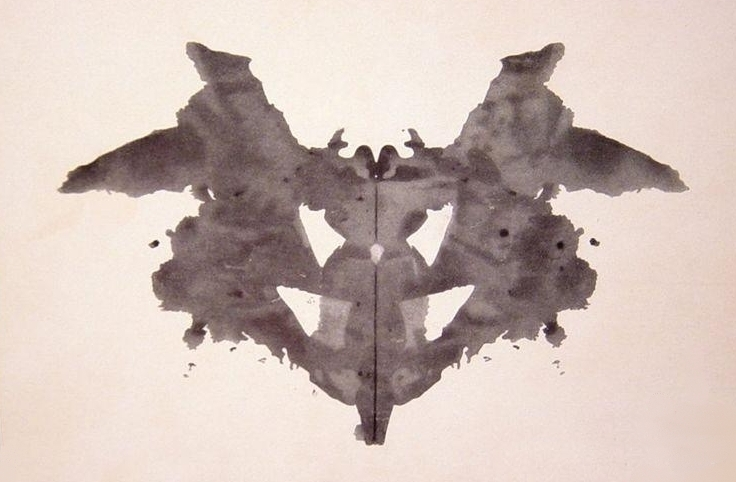

In [25]:
#another example
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
image

In [26]:
#generate caption
inputs= blip_processor(image, return_tensors= "pt").to(device, torch.float16)

generated_ids= model.generate(**inputs, max_new_tokens=20)

generated_text= blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)

generated_text= generated_text[0].strip()
generated_text

'a black and white ink drawing of a bat'

## multimodal Chat- based prompting

how abt question- ans with the image

lets do it

In [27]:
#load the image
image= Image.open(urlopen(car_path)).convert("RGB")

In [31]:
#we need to give our blip more than image i.e prompt
prompt= "Question: Write down what you see in this picture. Answer: "

inputs= blip_processor(image, text=prompt, return_tensors= "pt").to(device, torch.float16)


#generate text
generated_ids= model.generate(**inputs, max_new_tokens=30)

generated_text= blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text= generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: ____________'

the above only give you normal caption

lets make it more answering by playing with the prompt

In [32]:
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question:  What would it cost me to drive that car? Answer:"
inputs= blip_processor(image, text=prompt, return_tensors= "pt").to(device, torch.float16)


#generate text
generated_ids= model.generate(**inputs, max_new_tokens=30)

generated_text= blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
generated_text= generated_text[0].strip()
generated_text

'Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question:  What would it cost me to drive that car? Answer: $1,000,000'

### lets make full fledged chatbot

In [84]:
# from IPython.display import HTML, display
# import ipywidgets as widgets

# question=""

# def text_eventhandler(*args):
#   global question
#   question= args[0]["new"]

#   if question:
#     args[0]["owner"].value =""

#     #create prompt
#     if not memory:
#       prompt= "Question: " + question + "Answer: "
#     else:
#       template = "Question: {} Answer: {}"
#       prompt =" ".join(
#           [
#               template.format(memory[i][0],memory[i][1])
#               for i in range(len(memory))
#           ]
#       ) + "Question: " + question + "Answer: "

In [ ]:
inputs= blip_processor(image, text=prompt, return_tensors= "pt").to(device, torch.float16)


#generate text
generated_ids= model.generate(**inputs, max_new_tokens=100)

generated_text= blip_processor.batch_decode(
    generated_ids, skip_special_tokens=True
)
# generated_text= generated_text[0].strip("Question")[0]
generated_text = generated_text[0].strip().split("Question")[0]
# generated_text= generated_text[0].strip()

# generated_text

In [ ]:
#update memory
memory.append((question, generated_text))

# output=""

#assign to output
output.append_display_data(HTML("<b>USER:</b>" + question))
output.append_display_data(HTML("<b>MODEL:</b>" + generated_text)) # Corrected typo here

output.append_display_data(HTML("<br>"))



In [ ]:
#prepare widget
in_text= widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")

output= widgets.Output()
memory=[]

In [ ]:
# display(
#     widgets.VBox(
#         children=[output, in_text],
#         layout= widgets.Layout(display= "inline-flex", flex_flow= "column-reverse"),
#     )
# )

In [ ]:
# from IPython.display import HTML, display
# import ipywidgets as widgets
# import torch

# car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
# image = Image.open(urlopen(car_path)).convert("RGB")
# # === Setup shared variables first ===
# memory = []
# output = widgets.Output()

# # === Widget for user input ===
# in_text = widgets.Text()
# in_text.continuous_update = False

# # === Event handler function ===
# def text_eventhandler(change):
#     new_text = change["new"].strip()

#     # Only respond to non-empty input
#     if not new_text:
#         return

#     global question
#     question = new_text

#     # Clear box AFTER processing
#     change["owner"].unobserve(text_eventhandler, "value")  # Prevent double trigger
#     change["owner"].value = ""
#     change["owner"].observe(text_eventhandler, "value")

#     # Create prompt
#     if not memory:
#         prompt = f"Question: {question} Answer: "
#     else:
#         prompt = " ".join(
#             [f"Question: {q} Answer: {a}" for q, a in memory]
#         ) + f" Question: {question} Answer: "

#     print("Prompt sent to model:", prompt)

#     # Generate model output
#     inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
#     generated_ids = model.generate(**inputs, max_new_tokens=100)
#     generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#     generated_text = generated_text.strip().split("Question")[0]

#     print("Generated answer:", generated_text)

#     # Store in memory and display
#     memory.append((question, generated_text))
#     output.append_display_data(HTML(f"<b>USER:</b> {question}"))
#     output.append_display_data(HTML(f"<b>MODEL:</b> {generated_text}"))
#     output.append_display_data(HTML("<br>"))



# # === Hook up the handler ===
# in_text.observe(text_eventhandler, "value")

# # === Display everything ===
# # display(
# #     widgets.VBox(
# #         children=[output, in_text],
# #         layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
# #     )
# # )
